In [1]:
%matplotlib notebook

In [2]:
import os
import sys
import numpy as np

In [3]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d.axes3d import Axes3D
plt.ioff()

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
import data.analysis_tools as tools

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from keras.models import Model
from keras.layers import Input, Dense

Using TensorFlow backend.


### Prepare Data

In [8]:
X_raw = np.load(os.path.abspath('raw/cat_mouse/X.npy'))[2:,]
Y_raw = np.load(os.path.abspath('raw/cat_mouse/Y.npy'))

In [9]:
print(X_raw.shape)
print(Y_raw.shape)

(2, 11, 11)
(11, 11)


In [10]:
X_full = X_raw.reshape(2, 121).T
Y_full = Y_raw.reshape(121, 1)

In [11]:
print(X_full.shape)
print(Y_full.shape)

(121, 2)
(121, 1)


In [12]:
np.array_equal(X_raw, X_full.T.reshape(2, 11, 11))

True

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X_full,
                                                    Y_full,
                                                    test_size=0.10)

### Prepare Machine Learning Model

In [14]:
visible = Input(shape=(2,), name="input")

hidden1 = Dense(16, activation='relu', name="hidden1")(visible)
hidden2 = Dense(8, activation='relu', name="hidden2")(hidden1)
hidden3 = Dense(4, activation='relu', name="hidden3")(hidden2)
hidden4 = Dense(2, activation='relu', name="hidden4")(hidden3)

output = Dense(1, activation='sigmoid', name="ouput")(hidden4)

In [15]:
model = Model(inputs=visible, outputs=output)

In [16]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 16)                48        
_________________________________________________________________
hidden2 (Dense)              (None, 8)                 136       
_________________________________________________________________
hidden3 (Dense)              (None, 4)                 36        
_________________________________________________________________
hidden4 (Dense)              (None, 2)                 10        
_________________________________________________________________
ouput (Dense)                (None, 1)                 3         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

In [25]:
model.fit(X_train,
          Y_train,
          batch_size=108,
          epochs=10000,
          verbose=0,
          validation_data=(X_test, Y_test))

In [26]:
model.evaluate(X_test, Y_test, batch_size=13)

13/13 [==============================] - 0s


[0.0019010670948773623, 0.037816442549228668]

In [27]:
Y_pred = model.predict(X_full)

In [28]:
Y_pred.reshape(11, 11)

array([[ 0.73463506,  0.70924932,  0.68093359,  0.70632982,  0.69867325,
         0.69064474,  0.6822719 ,  0.66661489,  0.65058136,  0.63420004,
         0.55287308],
       [ 0.88260269,  0.91856706,  0.94023043,  0.94176513,  0.941073  ,
         0.93338323,  0.92204046,  0.89328116,  0.85557443,  0.80741721,
         0.74793321],
       [ 0.86734957,  0.90507132,  0.93204021,  0.93935066,  0.9411031 ,
         0.93415934,  0.91748857,  0.88725543,  0.84778237,  0.79764146,
         0.73612475],
       [ 0.8386544 ,  0.88597357,  0.91949391,  0.93058604,  0.93804246,
         0.93395531,  0.912696  ,  0.88093466,  0.83964872,  0.78750002,
         0.72396719],
       [ 0.80514628,  0.86065984,  0.90227729,  0.92066187,  0.92908943,
         0.93053538,  0.90765309,  0.8743099 ,  0.83116692,  0.77699244,
         0.71146917],
       [ 0.76661569,  0.83079982,  0.88009316,  0.90689862,  0.91818571,
         0.91773349,  0.90235007,  0.86737192,  0.82233143,  0.76611966,
         0.698

In [29]:
Y_raw

array([[ 0.73754153,  0.71235666,  0.67886615,  0.70394384,  0.72853928,
         0.65694995,  0.7355053 ,  0.66075447,  0.61515379,  0.66386239,
         0.634873  ],
       [ 0.89529525,  0.91613975,  0.95118422,  1.        ,  0.92916086,
         0.94871932,  0.93639481,  0.88956168,  0.8400493 ,  0.83147573,
         0.72468117],
       [ 0.92471332,  0.94673668,  0.90151109,  0.96693816,  0.94577216,
         0.92305219,  0.96029364,  0.87595113,  0.85719644,  0.78844711,
         0.7471868 ],
       [ 0.86255492,  0.91865824,  0.9442182 ,  0.89877827,  0.96527703,
         0.93987783,  0.92310578,  0.91008466,  0.88329225,  0.78817919,
         0.71701854],
       [ 0.76797771,  0.87145001,  0.89047262,  0.91860465,  0.93843104,
         0.94545065,  0.88581074,  0.87209302,  0.82826064,  0.72875362,
         0.70882006],
       [ 0.71294609,  0.8647519 ,  0.88350659,  0.86748473,  0.92112314,
         0.94909442,  0.91174579,  0.85060551,  0.8149716 ,  0.81384632,
         0.699

### 3D Plotting

In [35]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

In [36]:
X_raw[0].shape

(11, 11)

In [37]:
Y_pred.reshape(11, 11).shape

(11, 11)

In [38]:
p = ax.plot_wireframe(X_raw[0], X_raw[1], Y_raw,
                      alpha=0.25)
p = ax.plot_surface(X_raw[0], X_raw[1], Y_pred.reshape(11, 11),
                    alpha=0.25)

ax.set_xticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_zticks([0.0, 1.0])
ax.set_zticklabels(['low', 'high'])

# ax.invert_xaxis()
# ax.invert_yaxis()
# ax.invert_zaxis()

cset = ax.contour(X_raw[0], X_raw[1], Y_raw,
                  zdir='x',
                  offset=1.5,
                  cmap=plt.cm.coolwarm)
cset = ax.contour(X_raw[0], X_raw[1], Y_raw,
                  zdir='y',
                  offset=1.5,
                  cmap=plt.cm.coolwarm)
cset = ax.contour(X_raw[0], X_raw[1], Y_raw,
                  zdir='z',
                  offset=0.0,
                  cmap=plt.cm.coolwarm)

ax.set_xlim3d(0.0, 1.5);
ax.set_ylim3d(0.0, 1.5);
ax.set_zlim3d(0.0, 1.0);

fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.0)
ax.grid(False)

ax.view_init(elev=30., azim=-135)

<IPython.core.display.Javascript object>


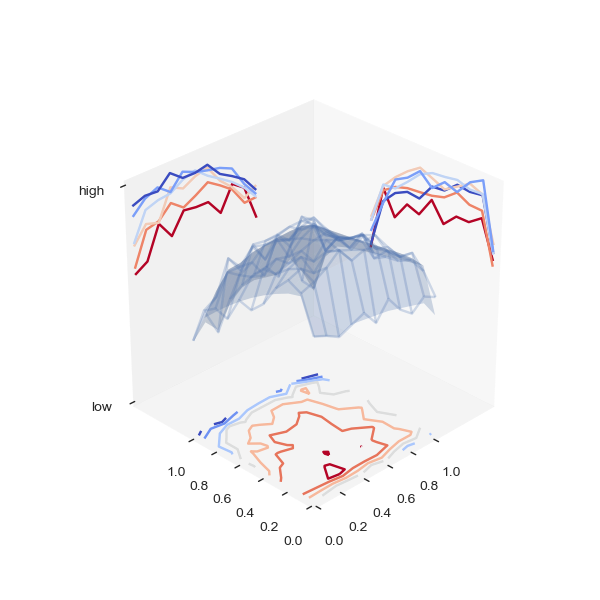

In [39]:
plt.show()